### Import Libraries

In [138]:
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import col, year, to_date, pandas_udf, StringType, size, split
import spacy
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import split, explode, desc
import seaborn as sns
import pandas as pd
import os

from embedders.my_sentence_transformer import MySentenceTransformer
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import matplotlib.pyplot as plt
from umap import UMAP

from sklearn.feature_extraction.text import TfidfVectorizer

from nlp_preprocessor import text_preprocessor
from collections import Counter

#### Load .env which contains OpenA API Key

In [139]:
# Load .env
from dotenv import load_dotenv
load_dotenv()

True

In [140]:
from openai import OpenAI
client = OpenAI()

#### Creat Spark Session

In [141]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

#### Read in reviews data

In [142]:
reviews_df = spark.read.parquet("yelp_reviews.parquet")

In [143]:
reviews_df.show()

+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|           review_id|             user_id|         business_id|stars|useful|funny|cool|                text|               date|
+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|KU_O5udG6zpxOg-Vc...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|  3.0|     0|    0|   0|If you decide to ...|2018-07-07 22:09:11|
|BiTunyQ73aT9WBnpR...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|  5.0|     1|    0|   1|I've taken a lot ...|2012-01-03 15:28:18|
|saUsX_uimxRlCVr67...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|  3.0|     0|    0|   0|Family diner. Had...|2014-02-05 20:30:30|
|AqPFMleE6RsU23_au...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|  5.0|     1|    0|   1|Wow!  Yummy, diff...|2015-01-04 00:01:03|
|Sx8TMOWLNuJBWer-0...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|  4.0|     1|    0|   1|Cu

#### Read in business data

In [144]:
# Read business data
businesses_df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)

In [145]:
# Use business with a high review_count
mid_rated_businesses = businesses_df[(businesses_df.stars > 2.5) & (businesses_df.stars < 3.5)].sort_values('review_count', ascending=False).head(50)

# Makes sure businesses are open
mid_rated_businesses = mid_rated_businesses[mid_rated_businesses.is_open == 1].sort_values('review_count', ascending=False).head(50)
mid_rated_businesses

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
113983,PP3BBaVxZLcJU54uP_wL6Q,Pat's King of Steaks,1237 E Passyunk Ave,Philadelphia,PA,19147,39.933201,-75.159266,3.0,4250,1,"{'RestaurantsReservations': 'False', 'Corkage': 'False', 'RestaurantsTakeOut': 'True', 'BYOBCorkage': ''no'', 'BikeParking': 'True', 'Alcohol': ''none'', 'RestaurantsAttire': ''casual'', 'BusinessAcceptsCreditCards': 'False', 'RestaurantsGoodForGroups': 'True', 'GoodForKids': 'True', 'WiFi': 'u'no'', 'Caters': 'False', 'HasTV': 'True', 'GoodForMeal': '{'dessert': False, 'latenight': True, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}', 'OutdoorSeating': 'True', 'RestaurantsDelivery': 'True', 'BusinessParking': '{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}', 'RestaurantsTableService': 'False', 'Ambience': '{'touristy': True, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': True, 'casual': False}', 'HappyHour': 'False', 'NoiseLevel': 'u'average'', 'DogsAllowed': 'True', 'RestaurantsPriceRange2': '2'}","Italian, American (Traditional), Sandwiches, Fast Food, Restaurants, Local Flavor, Cheesesteaks","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'Wednesday': '0:0-0:0', 'Thursday': '0:0-0:0', 'Friday': '0:0-0:0', 'Saturday': '0:0-0:0', 'Sunday': '0:0-0:0'}"
103544,wz8ZPfySQczcPgSyd33-HQ,Grand Sierra Resort and Casino,2500 E 2nd St,Reno,NV,89595,39.523349,-119.781101,3.0,3345,1,"{'GoodForKids': 'True', 'BusinessAcceptsCreditCards': 'True', 'WiFi': 'u'free'', 'RestaurantsPriceRange2': '2', 'BusinessAcceptsBitcoin': 'False', 'ByAppointmentOnly': 'False', 'OutdoorSeating': 'True', 'Ambience': '{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}', 'DogsAllowed': 'False', 'RestaurantsAttire': 'u'casual'', 'RestaurantsGoodForGroups': 'True'}","Nightlife, Hotels & Travel, Arts & Entertainment, Music Venues, Hotels, Casinos, Event Planning & Services, Resorts","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'Wednesday': '0:0-0:0', 'Thursday': '0:0-0:0', 'Friday': '0:0-0:0', 'Saturday': '0:0-0:0', 'Sunday': '0:0-0:0'}"
95286,Eb1XmmLWyt_way5NNZ7-Pw,Louis Armstrong New Orleans International Airport MSY,"1 Terminal Dr, Kenner",Kenner,LA,70062,29.995874,-90.255164,3.0,1789,1,"{'WiFi': 'u'free'', 'OutdoorSeating': 'False', 'RestaurantsPriceRange2': '2', 'GoodForMeal': '{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}', 'RestaurantsDelivery': 'False', 'RestaurantsTakeOut': 'True', 'ByAppointmentOnly': 'False'}","Hotels & Travel, Airports, Transportation","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'Wednesday': '0:0-0:0', 'Thursday': '0:0-0:0', 'Friday': '0:0-0:0', 'Saturday': '0:0-0:0', 'Sunday': '0:0-0:0'}"
181,ORL4JE6tz3rJxVqkdKfegA,Gaylord Opryland Resort & Convention Center,2800 Opryland Dr,Nashville,TN,37214,36.211592,-86.694319,3.0,1639,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppointmentOnly': 'True', 'RestaurantsDelivery': 'True', 'RestaurantsPriceRange2': '3', 'RestaurantsGoodForGroups': 'True', 'GoodForKids': 'True', 'OutdoorSeating': 'True', 'RestaurantsReservations': 'True', 'HasTV': 'True', 'RestaurantsTakeOut': 'True', 'NoiseLevel': 'u'very_loud'', 'RestaurantsAttire': ''casual'', 'BusinessAcceptsBitcoin': 'False', 'Music': '{'dj': True, 'background_music': True, 'no_music': False, 'jukebox': False, 'live': True, 'video': False, 'karaoke': True}', 'BusinessParking': '{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}', 'GoodForMeal': '{'dessert': False, 'latenight': True, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}', 'BYOBCorkage': ''no'', 'Smoking': 'u'outdoor'', 'BYOB': 'True', 'RestaurantsTableService': 'True', 'Caters': 'True', 'Alcohol':

#### Use mid rated business

In [146]:
# Pick business with a middle-of-the-pack rating
mid_business_id = 'Eb1XmmLWyt_way5NNZ7-Pw'

In [147]:
# Retrieve reviews for top business
mid_business_reviews = reviews_df.filter(col('business_id') == mid_business_id)

In [148]:
mid_business_reviews.show()

[Stage 22:=========================>                                (4 + 5) / 9]

+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|           review_id|             user_id|         business_id|stars|useful|funny|cool|                text|               date|
+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|vHxvcQqc74UH6JyYB...|9zrDHoXDTXCGKf1c6...|Eb1XmmLWyt_way5NN...|  4.0|     0|    0|   0|We flew out of Ne...|2018-09-25 04:35:41|
|8aFLU-pnuJNSdBkhS...|J7p-HWVrtr9lPbTae...|Eb1XmmLWyt_way5NN...|  3.0|     0|    0|   0|Very cool little ...|2016-01-17 11:01:36|
|YSENzy08BtMupX7Wh...|05A1WpXkjCbVHCodT...|Eb1XmmLWyt_way5NN...|  1.0|     0|    0|   0|If it is possible...|2012-01-03 18:04:51|
|H3ELWtFc0vT0szeZy...|e9UPHIeBJ54Z4kaaG...|Eb1XmmLWyt_way5NN...|  2.0|     0|    1|   0|Awful pat down ex...|2014-11-12 15:03:01|
|PvuIC9MwM58KqF9PX...|Zln95DzQlnxjzkGVx...|Eb1XmmLWyt_way5NN...|  5.0|     0|    0|   0|Sm

In [149]:
mid_business_reviews.count()

1850

In [150]:
mid_business_reviews_df = mid_business_reviews.toPandas()

In [175]:
# Stop the SparkSession
spark.stop()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


#### Lemmatize pre-processed reviews (spacy)
We tokenize each review into words, and keep words that carry semantic meaning. We normalize these words into their base form to eliminate redundant meaning and sort of prune our vocabulary.

In [151]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
negations = ['no', 'not', 'never']

def lemmatize(text):
    pre_processed_text = text_preprocessor(text)
    doc = nlp(pre_processed_text)
    return " ".join([t.lemma_ for t in doc if t.is_alpha and (not t.is_stop or t in negations)])

In [152]:
mid_business_reviews_df["lemmas"] = mid_business_reviews_df["text"].apply(lemmatize)

In [153]:
mid_business_reviews_df.shape

(1850, 10)

In [154]:
mid_business_reviews_df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,lemmas
0,vHxvcQqc74UH6JyYBhsRCw,9zrDHoXDTXCGKf1c6V9Dbw,Eb1XmmLWyt_way5NNZ7-Pw,4.0,0,0,0,"We flew out of New Orleans to Seattle on a really early morning flight, 6:30 am. Got there at least 2 hours ahead of time, to make sure we got through security in time. Security didn't even open until about 4:45 am and since my daughter had a flight at 5:30 am it made for an interesting time getting to the gate. The restrooms weren't open completely before they opened the concourse we were in. The restaurant was open and it was relatively priced, for airport food. The airport was clean and security left a little to be desired. My husband was in a wheelchair and they took him off to the side and just about stripped searched him before they let him through. They made me take my camera and computer out of the bag they were in before going through the scanner. When my carry on was scanned they pulled it aside, because my candy bags were visible. They took my candy bags out and ran their bomb sniffer over the bags to make sure they were ok. It took me a little bit to pack everything back up like we had it, but we made it. Made sure that we didn't have belts and loose shoes, flip flops and slippers, to help speed us through. I understand why the security procedures but they can go a little extreme. Will fly out of New Orleans again not only for the price but for the service.",2018-09-25 04:35:41,fly new orleans seattle early morning flight get hour ahead time sure get security time security open daughter flight interesting time get gate restroom open completely open concourse restaurant open relatively price airport food airport clean security leave little desire husband wheelchair take strip search let camera computer bag go scanner carry scan pull aside candy bag visible take candy bag run bomb sniffer bag sure ok take little bit pack like sure belt loose shoe flip flop slipper help speed understand security procedure little extreme fly new orleans price service
1,8aFLU-pnuJNSdBkhSOatlw,J7p-HWVrtr9lPbTaeSR0GQ,Eb1XmmLWyt_way5NNZ7-Pw,3.0,0,0,0,Very cool little airport. We had to land here after a flight to Miami got grounded. Landed at 6:43am and we had a few good food options. Can't remember the name of the spot but very good fresh made biscuits (they even have a window to watch them get made!). \n\nThree stars due to lack of power plugs and very dated uncomfortable seating.,2016-01-17 11:01:36,cool little airport land flight miami get ground land good food option remember spot good fresh biscuit window watch star lack power plug dated uncomfortable seating
2,YSENzy08BtMupX7WhViNDg,05A1WpXkjCbVHCodTSc6sg,Eb1XmmLWyt_way5NNZ7-Pw,1.0,0,0,0,"If it is possible for an airport to rank below Charlotte-Douglas International, MSY has accomplished that feat. No good options for food or drink. Terrible service and super bored/hyper-excited to serve and protect TSA agents lead to a miserable experience. \n\nThe city may be the Big Easy, but the airport ain't.",2012-01-03 18:04:51,possible airport rank charlotte douglas international msy accomplish feat good option food drink terrible service super bore hyper excited serve protect tsa agent lead miserable experience city big easy airport
3,H3ELWtFc0vT0szeZy_iQ-g,e9UPHIeBJ54Z4kaaGSW7yQ,Eb1XmmLWyt_way5NNZ7-Pw,2.0,0,1,0,Awful pat down experience to get in. That TSA agent made it to 2nd base with a whole line of people watching. I was mortified. Left a sour taste in my mouth-- but what's my other option? Fly into Baton Rouge? Pah.,2014-11-12 15:03:01,awful pat experience tsa agent base line people watch mortify leave sour taste option fly baton rouge pah
4,PvuIC9MwM58KqF9PXPTymA,Zln95DzQlnxjzkGVxsm4GA,Eb1XmmLWyt_way5NNZ7-Pw,5.0,0,0,0,Small but efficient. NOLA is BIG in personality so I was surprised by such a miniature airport. Not a fan of the limited number of eateries or shopping. I was stuck there for three extra hours due to a storm so I got b

#### Extract year for visualizing review counts trends over years

In [155]:
# extract year from date
mid_business_reviews_df['year'] = pd.to_datetime(mid_business_reviews_df.date).dt.year

In [156]:
mid_business_reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,lemmas,year
0,vHxvcQqc74UH6JyYBhsRCw,9zrDHoXDTXCGKf1c6V9Dbw,Eb1XmmLWyt_way5NNZ7-Pw,4.0,0,0,0,"We flew out of New Orleans to Seattle on a really early morning flight, 6:30 am. Got there at least 2 hours ahead of time, to make sure we got through security in time. Security didn't even open until about 4:45 am and since my daughter had a flight at 5:30 am it made for an interesting time getting to the gate. The restrooms weren't open completely before they opened the concourse we were in. The restaurant was open and it was relatively priced, for airport food. The airport was clean and security left a little to be desired. My husband was in a wheelchair and they took him off to the side and just about stripped searched him before they let him through. They made me take my camera and computer out of the bag they were in before going through the scanner. When my carry on was scanned they pulled it aside, because my candy bags were visible. They took my candy bags out and ran their bomb sniffer over the bags to make sure they were ok. It took me a little bit to pack everything back up like we had it, but we made it. Made sure that we didn't have belts and loose shoes, flip flops and slippers, to help speed us through. I understand why the security procedures but they can go a little extreme. Will fly out of New Orleans again not only for the price but for the service.",2018-09-25 04:35:41,fly new orleans seattle early morning flight get hour ahead time sure get security time security open daughter flight interesting time get gate restroom open completely open concourse restaurant open relatively price airport food airport clean security leave little desire husband wheelchair take strip search let camera computer bag go scanner carry scan pull aside candy bag visible take candy bag run bomb sniffer bag sure ok take little bit pack like sure belt loose shoe flip flop slipper help speed understand security procedure little extreme fly new orleans price service,2018
1,8aFLU-pnuJNSdBkhSOatlw,J7p-HWVrtr9lPbTaeSR0GQ,Eb1XmmLWyt_way5NNZ7-Pw,3.0,0,0,0,Very cool little airport. We had to land here after a flight to Miami got grounded. Landed at 6:43am and we had a few good food options. Can't remember the name of the spot but very good fresh made biscuits (they even have a window to watch them get made!). \n\nThree stars due to lack of power plugs and very dated uncomfortable seating.,2016-01-17 11:01:36,cool little airport land flight miami get ground land good food option remember spot good fresh biscuit window watch star lack power plug dated uncomfortable seating,2016
2,YSENzy08BtMupX7WhViNDg,05A1WpXkjCbVHCodTSc6sg,Eb1XmmLWyt_way5NNZ7-Pw,1.0,0,0,0,"If it is possible for an airport to rank below Charlotte-Douglas International, MSY has accomplished that feat. No good options for food or drink. Terrible service and super bored/hyper-excited to serve and protect TSA agents lead to a miserable experience. \n\nThe city may be the Big Easy, but the airport ain't.",2012-01-03 18:04:51,possible airport rank charlotte douglas international msy accomplish feat good option food drink terrible service super bore hyper excited serve protect tsa agent lead miserable experience city big easy airport,2012
3,H3ELWtFc0vT0szeZy_iQ-g,e9UPHIeBJ54Z4kaaGSW7yQ,Eb1XmmLWyt_way5NNZ7-Pw,2.0,0,1,0,Awful pat down experience to get in. That TSA agent made it to 2nd base with a whole line of people watching. I was mortified. Left a sour taste in my mouth-- but what's my other option? Fly into Baton Rouge? Pah.,2014-11-12 15:03:01,awful pat experience tsa agent base line people watch mortify leave sour taste option fly baton rouge pah,2014
4,PvuIC9MwM58KqF9PXPTymA,Zln95DzQlnxjzkGVxsm4GA,Eb1XmmLWyt_way5NNZ7-Pw,5.0,0,0,0,Small but efficient. NOLA is BIG in personality so I was surprised by such a miniature airport. Not a fan of the limited number of eateries or shopping. I was stuck there for three extra hours 

In [157]:
business_reviews_per_year = mid_business_reviews_df.year.value_counts().sort_index()
business_reviews_per_year = business_reviews_per_year.reset_index()
business_reviews_per_year.columns = ['year', 'num_reviews']

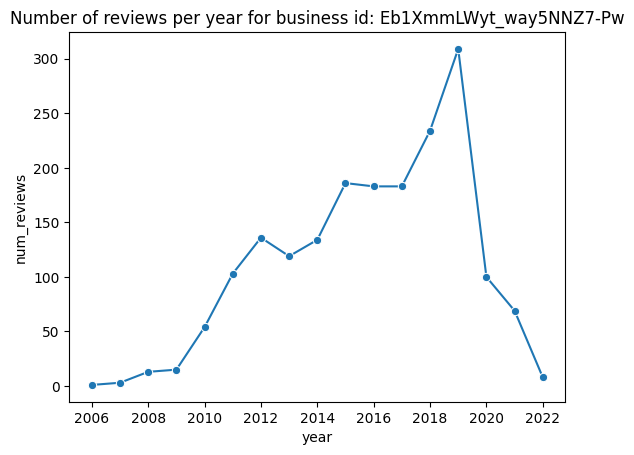

In [158]:
sns.lineplot(x='year', y='num_reviews', marker='o', data=business_reviews_per_year)
plt.title(f"Number of reviews per year for business id: {mid_business_id}")
plt.show()

In [159]:
mid_business_reviews_df.shape

(1850, 11)

### Embeddings

In [160]:
my_mpnet_transformer = MySentenceTransformer(model_name='paraphrase-MiniLM-L3-v2')

In [161]:
embs = my_mpnet_transformer.transform_sentences(mid_business_reviews_df.text)

#### Normalize embeddings

In [162]:
normalized_embs = normalize(embs)

In [163]:
mid_business_reviews_df['embeddings'] = normalized_embs.tolist()

### Finding best k(number fo clusters to use)

## 📊 Clustering Evaluation Metric Summary

| Metric | One-Sentence Explanation |
|--------|---------------------------|
| **Silhouette Score** | Measures how well each point fits within its assigned cluster by comparing its cohesion to its separation from other clusters (higher = better). |
| **Davies–Bouldin Index (DBI)** | Evaluates how similar each cluster is to its most similar neighboring cluster, penalizing overlapping or poorly separated clusters (lower = better). |
| **Calinski–Harabasz Index (CHI)** | Compares between-cluster dispersion to within-cluster dispersion to assess how well clusters are separated (higher = better). |
| **Average Intra-Cluster Cosine Similarity** | Computes the average semantic similarity between points within the same cluster to measure theme tightness (higher = more coherent clusters). |
| **Inter-Centroid Cosine Similarity** | Measures similarity between cluster centroids to show how distinct clusters are from one another (lower = better separation). |


In [164]:
def evaluate_k_range(embeddings, k_values, use_cosine_silhouette=True):
    results = []

    for k in k_values:
        print(f"Evaluating k={k}...")

        # Fit KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings)
        centroids = kmeans.cluster_centers_

        # ---- GLOBAL METRICS ----
        # 1. Silhouette Score (cosine recommended for embeddings)
        if use_cosine_silhouette:
            dist_matrix = cosine_distances(embeddings)
            sil = silhouette_score(dist_matrix, labels, metric="precomputed")
        else:
            sil = silhouette_score(embeddings, labels)

        # 2. Davies-Bouldin (lower = better)
        dbi = davies_bouldin_score(embeddings, labels)

        # 3. Calinski-Harabasz (higher = better)
        chi = calinski_harabasz_score(embeddings, labels)

        # ---- PER-CLUSTER COHESION ----
        intra_cosines = []
        for cluster_id in range(k):
            cluster_embs = embeddings[labels == cluster_id]

            if len(cluster_embs) > 1:
                cos_sim = cosine_similarity(cluster_embs)
                avg_intra = np.mean(cos_sim[np.triu_indices_from(cos_sim, k=1)])
            else:
                avg_intra = np.nan  # singleton cluster

            intra_cosines.append(avg_intra)

        avg_intra_cluster_cos = np.nanmean(intra_cosines)

        # ---- INTER-CLUSTER SEPARATION ----
        centroid_cos = cosine_similarity(centroids)
        # mask diagonal 1.0s
        separation = np.nanmean(
            centroid_cos[~np.eye(centroid_cos.shape[0], dtype=bool)]
        )

        results.append({
            "k": k,
            "silhouette": sil,
            "davies_bouldin": dbi,
            "calinski_harabasz": chi,
            "avg_intra_cosine": avg_intra_cluster_cos,
            "inter_centroid_cosine": separation
        })

    return pd.DataFrame(results)


In [166]:
k_values = range(2, 13)   # test k=4 through 12
results_df = evaluate_k_range(normalized_embs, k_values)
results_df

Evaluating k=2...
Evaluating k=3...
Evaluating k=4...
Evaluating k=5...
Evaluating k=6...
Evaluating k=7...
Evaluating k=8...
Evaluating k=9...
Evaluating k=10...
Evaluating k=11...
Evaluating k=12...


,k,silhouette,davies_bouldin,calinski_harabasz,avg_intra_cosine,inter_centroid_cosine
0,2,0.119195,5.160284,61.349167,0.352508,0.893151
1,3,0.052715,4.708210,56.500913,0.386217,0.857572
2,4,0.046809,4.503530,49.427635,0.402457,0.839327
3,5,0.042008,4.309610,45.120034,0.417787,0.823619
4,6,0.040053,4.386887,40.695555,0.417696,0.810602
5,7,0.041296,4.201477,37.796951,0.416916,0.803150
6,8,0.043246,4.115093,35.221079,0.424853,0.790149
7,9,0.046764,3.931334,33.311710,0.431784,0.781454
8,10,0.038276,4.119091,30.958228,0.427055,0.760400
9,11,0.041955,3.923015,29.486188,0.447695,0.771570


In [167]:
# Assign a rank to each k, assign weights to each metric
results_df["score"] = (
    1 * results_df["silhouette"].rank(ascending=False) +
    2 * results_df["avg_intra_cosine"].rank(ascending=False) +
    3 * results_df["inter_centroid_cosine"].rank(ascending=True) +
    1 * results_df["davies_bouldin"].rank(ascending=True) +
    1 * results_df["calinski_harabasz"].rank(ascending=False)
)

In [168]:
results_df.sort_values("score", ascending=False)

,k,silhouette,davies_bouldin,calinski_harabasz,avg_intra_cosine,inter_centroid_cosine,score
0,2,0.119195,5.160284,61.349167,0.352508,0.893151,68.0
1,3,0.052715,4.708210,56.500913,0.386217,0.857572,64.0
2,4,0.046809,4.503530,49.427635,0.402457,0.839327,60.0
4,6,0.040053,4.386887,40.695555,0.417696,0.810602,57.0
5,7,0.041296,4.201477,37.796951,0.416916,0.803150,54.0
3,5,0.042008,4.309610,45.120034,0.417787,0.823619,53.0
6,8,0.043246,4.115093,35.221079,0.424853,0.790149,41.0
8,10,0.038276,4.119091,30.958228,0.427055,0.760400,35.0
10,12,0.036212,4.063634,27.996567,0.445051,0.763854,35.0
7,9,0.046764,3.931334,33.311710,0.431784,0.781454,32.0


In [169]:
best_k = int(results_df.sort_values("score", ascending=False).iloc[0]["k"])
best_k

2

#### Using best_k

In [170]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(normalized_embs)

In [171]:
mid_business_reviews_df['cluster_id'] = labels

In [172]:
mid_business_reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,lemmas,year,embeddings,cluster_id
0,vHxvcQqc74UH6JyYBhsRCw,9zrDHoXDTXCGKf1c6V9Dbw,Eb1XmmLWyt_way5NNZ7-Pw,4.0,0,0,0,"We flew out of New Orleans to Seattle on a really early morning flight, 6:30 am. Got there at least 2 hours ahead of time, to make sure we got through security in time. Security didn't even open until about 4:45 am and since my daughter had a flight at 5:30 am it made for an interesting time getting to the gate. The restrooms weren't open completely before they opened the concourse we were in. The restaurant was open and it was relatively priced, for airport food. The airport was clean and security left a little to be desired. My husband was in a wheelchair and they took him off to the side and just about stripped searched him before they let him through. They made me take my camera and computer out of the bag they were in before going through the scanner. When my carry on was scanned they pulled it aside, because my candy bags were visible. They took my candy bags out and ran their bomb sniffer over the bags to make sure they were ok. It took me a little bit to pack everything back up like we had it, but we made it. Made sure that we didn't have belts and loose shoes, flip flops and slippers, to help speed us through. I understand why the security procedures but they can go a little extreme. Will fly out of New Orleans again not only for the price but for the service.",2018-09-25 04:35:41,fly new orleans seattle early morning flight get hour ahead time sure get security time security open daughter flight interesting time get gate restroom open completely open concourse restaurant open relatively price airport food airport clean security leave little desire husband wheelchair take strip search let camera computer bag go scanner carry scan pull aside candy bag visible take candy bag run bomb sniffer bag sure ok take little bit pack like sure belt loose shoe flip flop slipper help speed understand security procedure little extreme fly new orleans price service,2018,"[0.09098508954048157, 0.04890679568052292, 0.015396087430417538, -0.06195881962776184, -0.05978764221072197, 0.03456703573465347, -0.09286471456289291, -0.013121198862791061, -0.08032652735710144, 0.025493601337075233, 0.07209860533475876, 0.047854118049144745, 0.06949912756681442, -0.07450051605701447, 0.03834393993020058, -0.04970784857869148, 0.10444821417331696, -0.1573643833398819, -0.07116059213876724, 0.021987246349453926, -0.02302996627986431, -0.032847315073013306, 0.04654930531978607, -0.045228272676467896, 0.008628817275166512, 0.057702913880348206, -0.04521827772259712, 0.03826170042157173, 0.018420260399580002, -0.005056735593825579, -0.0329868346452713, -0.042764198035001755, -0.029652796685695648, -0.03552285581827164, 0.07263986766338348, -0.0466042160987854, 0.0366712249815464, -0.07350647449493408, 0.03792400285601616, 0.03474225476384163, 0.04081796109676361, -0.027128254994750023, -0.012120744213461876, 0.04315248504281044, 0.015989692881703377, 0.09411188960075378, 0.06018493324518204, 0.07071974128484726, -0.015890706330537796, -0.009282069280743599, -0.12301373481750488, 0.03771868348121643, 0.031105609610676765, -0.012428190559148788, -0.028039470314979553, 0.012921695597469807, 0.028491856530308723, -0.11183080822229385, 0.010525169782340527, -0.028205085545778275, 0.002988203428685665, 0.07885599881410599, -0.01764049008488655, -0.0046313609927892685, -0.06085123121738434, -0.029813209548592567, -0.01508712861686945, -0.04457476735115051, 0.04732433706521988, -0.0513322651386261, 8.7755783169996e-05, -0.03930084407329559, 0.05411912500858307, -0.08174353837966919, -0.07366430014371872, 0.06207380071282387, -0.1044459342956543, 0.0032850983552634716, 0.0509122870862484, -0.02820814587175846, 0.08246788382530212, -0.013242592103779316, 0.036578647792339325, 0.11933941394090652, -0.013745049946010113, -0.03079160489141941, -0.033389151096343994, 0.023030750453472137,

### Compute Per-Cluster Summary Stats

For each cluster:
- size
- average intra-cluster cosine
- centroid similarity
- top terms (TF-IDF)
- representative examples

#### Size(counts in cluster)

In [173]:
mid_business_reviews_df.cluster_id.value_counts().sort_values(ascending=False)

cluster_id
1    1288
0     562
Name: count, dtype: int64

#### Average intra-cluster cosine

In [174]:
# Average intra cluster cosine similarity score
def avg_intra_cos(cluster_embs):
    sim = cosine_similarity(cluster_embs)
    return sim[np.triu_indices_from(sim, 1)].mean()

In [134]:
cluster_intra_cos = {
    cid: avg_intra_cos(normalized_embs[labels == cid]) for cid in range(best_k)
}

In [135]:
cluster_intra_cos

{0: 0.38591844, 1: 0.48323467, 2: 0.4037446, 3: 0.33692983}

#### Centroid similarity
Tells us how unique our clusters are, low similarity is the goal

In [136]:
### Centroid similarity
centroids = np.vstack([normalized_embs[labels == c].mean(axis=0) for c in range(best_k)])
center_sims = cosine_similarity(centroids)

nearest_centroid_similarity = {}
nearest_to = {}

for i, c in enumerate(range(best_k)):
    row = center_sims[i]
    masked = np.delete(row, i)        # remove self-similarity
    nearest_centroid_similarity[c] = masked.max()
    # map back to original cluster index

    nearest_idx = np.argmax(masked)
    # map back to original cluster index
    
    nearest_cluster = nearest_idx if nearest_idx < i else nearest_idx + 1
    nearest_to[c] = nearest_cluster

In [137]:
nearest_centroid_similarity

{0: 0.87486374, 1: 0.8829993, 2: 0.8697095, 3: 0.8829993}

In [96]:
nearest_to

{0: 2, 1: 4, 2: 4, 3: 2, 4: 2, 5: 2}

In [ ]:
# map back to original cluster index
    nearest_cluster = nearest_idx if nearest_idx < i else nearest_idx + 1
    nearest_to[i] = nearest_cluster

#### Top terms(TF-IDF)

#### i. "Learn the noise"
Identify and remove generic terms that appear in 80% of clusters

In [85]:
# Count unigrams across all documents
all_words = " ".join(mid_business_reviews_df.lemmas).split()
freq = Counter(all_words)

# How many documents each word appears in
doc_freq = {}
for word in freq:
    doc_freq[word] = sum(mid_business_reviews_df.lemmas.str.contains(fr"\b{word}\b"))

# remove overly common terms
noisy_unigrams = {w for w, df in doc_freq.items() if df > 0.8 * len(mid_business_reviews_df)}

# remove very short tokens
noisy_unigrams = {w for w in noisy_unigrams if len(w) > 2}

print(len(noisy_unigrams), noisy_unigrams)

1 {'airport'}


In [68]:
# Add these generic terms to stop_words list
review_stopwords = {
    'good', 'great', 'nice', 'amazing', 'delicious', 'tasty',
    'food', 'place', 'spot', 'service', 'wait', 'line', 'time',
    'come', 'order', 'ordered', 'got', 'make', 'made', 'try',
    'eat', 'go', 'went', 'get', 'take', 'give', 'ask', 'staff',
    'people', 'customer', 'experience', 'really', 'pretty',
    'little', 'bit', 'lot', 'thing', 'things'
}

base_stopwords = set(TfidfVectorizer(stop_words="english").get_stop_words())
# full_stopwords = base_stopwords.union(noisy_unigrams, review_stopwords)

#### ii. Extract meaningful terms

In [69]:
tfidf = TfidfVectorizer(stop_words=list(base_stopwords), max_df=0.80, min_df=1, max_features=3000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(mid_business_reviews_df.lemmas)
top_terms_by_cluster = {}

for cid in range(best_k):
    idx = np.where(labels == cid)[0]
    sub_tfidf = tfidf_matrix[idx].mean(axis=0).A1
    top_idx = sub_tfidf.argsort()[::-1][:10]
    top_terms_by_cluster[cid] = [tfidf.get_feature_names_out()[i] for i in top_idx]

In [70]:
for cid, terms in top_terms_by_cluster.items():
    print(f"cluster {cid} top terms: {terms}")

cluster 0 top terms: ['new', 'orleans', 'new orleans', 'city', 'time', 'place', 'fly', 'food', 'nice', 'good']
cluster 1 top terms: ['tsa', 'people', 'line', 'security', 'rude', 'check', 'employee', 'like', 'work', 'staff']
cluster 2 top terms: ['easy', 'security', 'small', 'nice', 'like', 'terminal', 'good', 'pretty', 'need', 'clean']
cluster 3 top terms: ['bathroom', 'clean', 'place', 'restroom', 'dirty', 'seat', 'terminal', 'need', 'food', 'toilet']
cluster 4 top terms: ['flight', 'car', 'check', 'time', 'line', 'rental', 'shuttle', 'bag', 'security', 'baggage']
cluster 5 top terms: ['food', 'option', 'eat', 'place', 'food option', 'good', 'security', 'restaurant', 'small', 'easy']


#### Visualizing

/Users/safarifgisa/venvs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


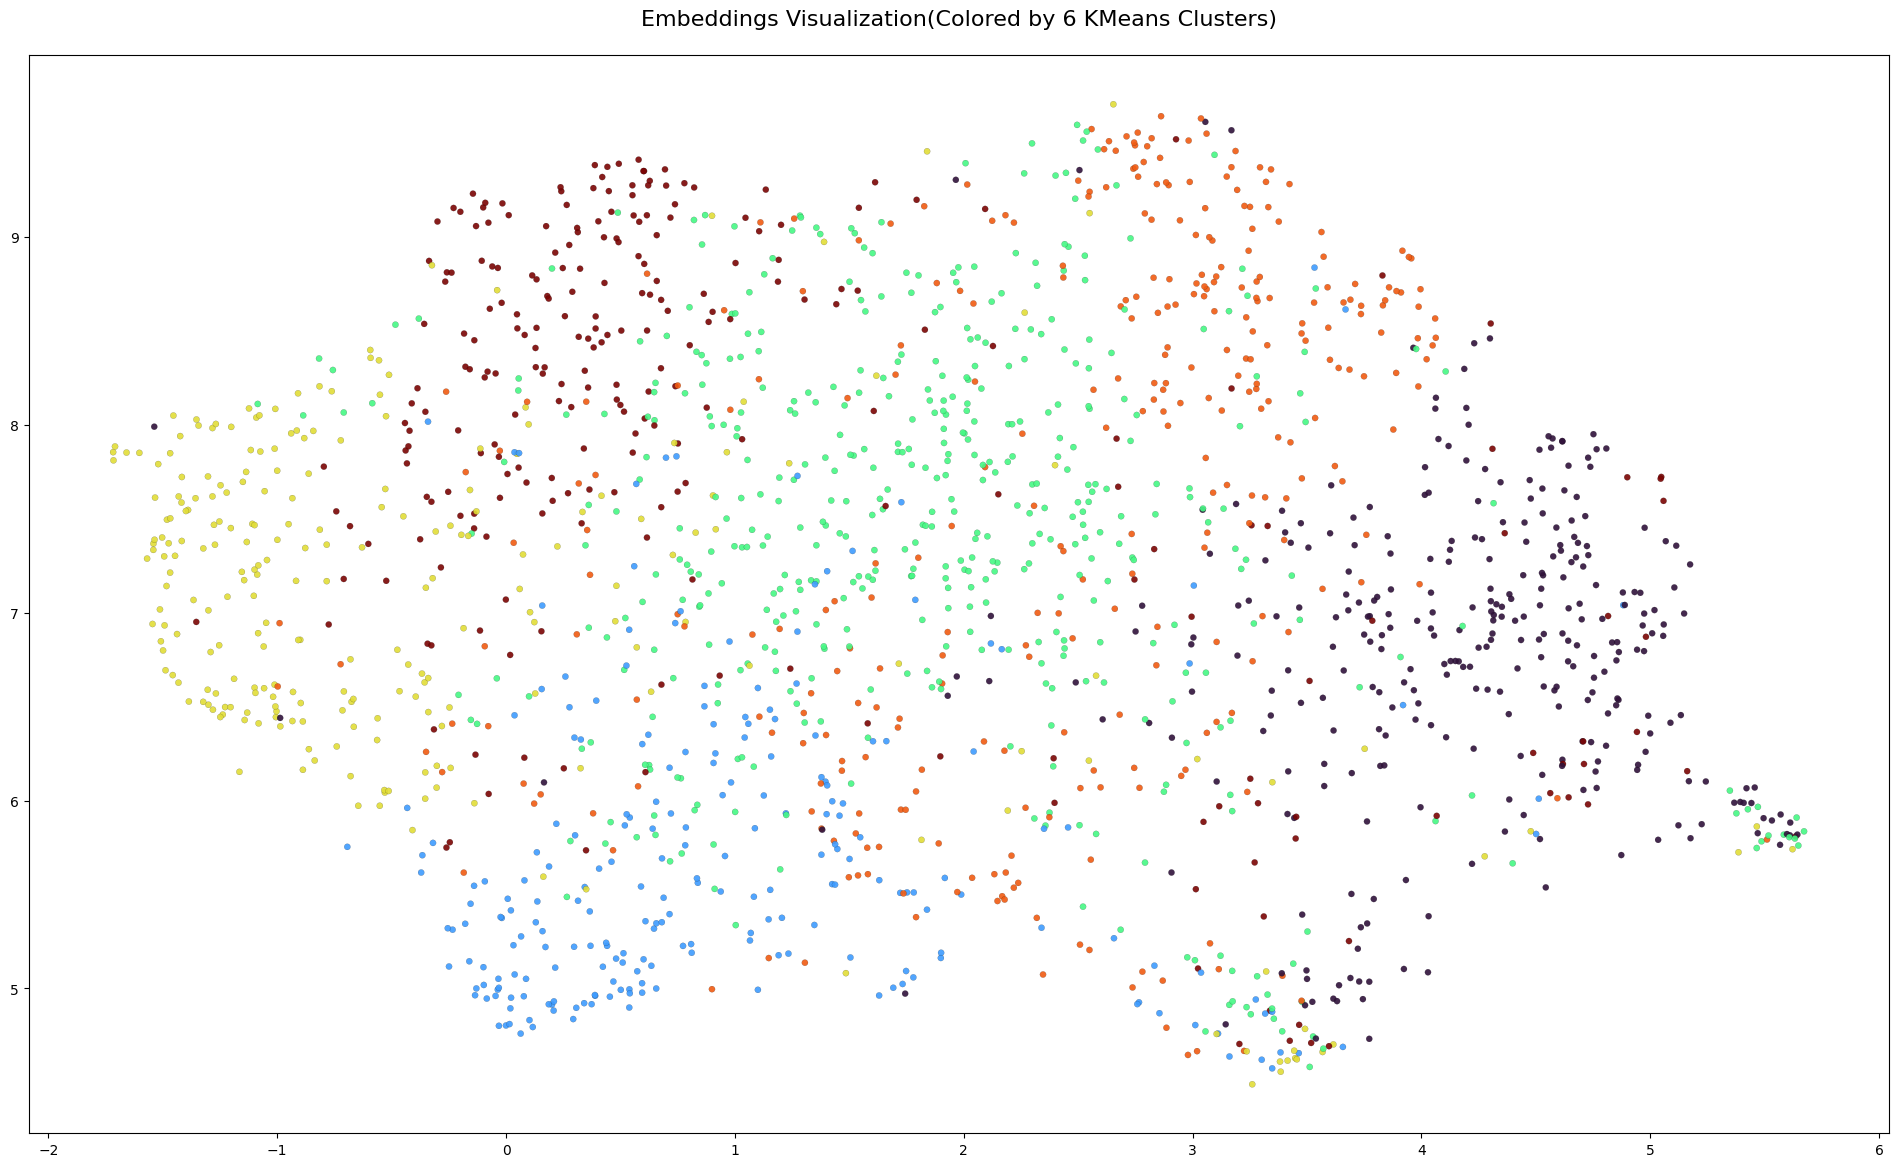

In [88]:
# UMAP visualization with cluster coloring
reducer = UMAP(n_components=2, random_state=42)

labels = mid_business_reviews_df.cluster_id
    
# Reduce to 2D
emb_2d = reducer.fit_transform(np.vstack(mid_business_reviews_df.embeddings.values))

plt.figure(figsize=(24, 14))

# Plot clusters
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    s=20,
    cmap='turbo',
    alpha=0.9,
    edgecolor='k',
    linewidth=0.1
)

plt.title(f"Embeddings Visualization(Colored by {best_k} KMeans Clusters)", fontsize=16, y=1.02)
plt.show()


#### Cluster Interpretability
Turn clusters into themes

#### i. Pull most representative reviews of a cluster
These are cluster centroid example reviews

In [72]:
def get_centroid_examples(df, emb_array, kmeans, cluster_id, top_n=3):
    # Identify which rows belong to this cluster
    idx = np.where(df.cluster_id.values == cluster_id)[0]

    # Get their embeddings
    cluster_embs = emb_array[idx]

    # Get the centroid for this cluster
    centroid = kmeans.cluster_centers_[cluster_id].reshape(1, -1)

    # Compute cosine similarity to centroid
    sims = cosine_similarity(cluster_embs, centroid).flatten()

    # Sort by similarity (descending)
    top_indices = sims.argsort()[::-1][:top_n]

    # Map back to original DF indices
    original_indices = idx[top_indices]

    # Return the actual review texts
    return df.iloc[original_indices][["text", "stars"]]

In [74]:
centroid_examples = {}

for cid in range(best_k):
    centroid_examples[cid] = get_centroid_examples(
        mid_business_reviews_df,
        normalized_embs,
        kmeans,
        cid
    )

In [89]:
centroid_examples[0]

,text,stars
879,"I have been to this airport a few times and I really like it. It is easy to navigate, seems to be pretty organized, and it is relatively small considering New Orleans is a huge destination. You get off your plane and in the blink of an eye, you have your bags and are outside in the humidity waiting for a car. I LOVE IT. The staff is great, or maybe that is just because I am so happy to be in a great city. Either way, this airport is great. One negative is that the stores in the airport close pretty early so if you have a later flight (after 9pm), I would say to make sure you bring what you want, because the shops are closed by then. Other than that this airport is updated nicely and easy to navigate. You can't expect much more from an airport.",3.0
229,"While I have to say, I know that New Orleans isn't a gigantic city, this airport is little bitty! \n\nThat being said, it's small, quiet, and there aren't a lot of food options if you're coming early, or arriving late. \n\nI do have to point out that this airport is not very close to the city proper, so be prepared to have a friend pick you up, or arrange a ride on the shuttle.",3.0
690,"I'm not sure how excited one can be about an airport - they are all pretty much the same with people coming and going. I was surprised by how small this airport is for such a huge destination like New Orleans. Still, it was an efficient operation and I look forward to returning.\n\nIt was easy to get a taxi when we arrived although there was a bit of a wait. Too bad MSY is so far from downtown and the French Quarter. But I realize there is more to the city than just that area so it's all good.\n\nWhen we flew out of NOLA on a Saturday there was ZERO wait time at the security gate. That was really nice cuz I was ready to get home and sit on my couch and nurse my hangover. The mimosa at the airport bar helped a lot for easing my queasy stomach.\n\nI will say that this airport has one of the best bathrooms I've ever visited. I'm talking about the one just outside the security gate - clean and large and not too cold or stale. Who would've thunk it?\n\nAlso, the HUGE statue of Louis Armstrong is pretty cool. Gotta represent!",3.0


#### ii. Sentiment per cluster

In [77]:
cluster_sentiment = {}

for cid in range(best_k):
    stars = mid_business_reviews_df[mid_business_reviews_df.cluster_id == cid]["stars"]
    
    cluster_sentiment[cid] = {
        "count": len(stars),
        "avg_rating": stars.mean(),
        "pct_positive": (stars >= 4).mean(),
        "pct_negative": (stars <= 2).mean(),
        "pct_neutral": ((stars > 2) & (stars < 4)).mean(),
    }

cluster_sentiment

{0: {'count': 312,
  'avg_rating': 3.230769230769231,
  'pct_positive': 0.42948717948717946,
  'pct_negative': 0.2403846153846154,
  'pct_neutral': 0.3301282051282051},
 1: {'count': 229,
  'avg_rating': 2.3973799126637556,
  'pct_positive': 0.21397379912663755,
  'pct_negative': 0.5676855895196506,
  'pct_neutral': 0.2183406113537118},
 2: {'count': 478,
  'avg_rating': 3.407949790794979,
  'pct_positive': 0.48535564853556484,
  'pct_negative': 0.1903765690376569,
  'pct_neutral': 0.32426778242677823},
 3: {'count': 250,
  'avg_rating': 2.692,
  'pct_positive': 0.296,
  'pct_negative': 0.488,
  'pct_neutral': 0.216},
 4: {'count': 323,
  'avg_rating': 2.823529411764706,
  'pct_positive': 0.3219814241486068,
  'pct_negative': 0.3746130030959752,
  'pct_neutral': 0.30340557275541796},
 5: {'count': 258,
  'avg_rating': 2.8410852713178296,
  'pct_positive': 0.3023255813953488,
  'pct_negative': 0.4108527131782946,
  'pct_neutral': 0.2868217054263566}}

#### Generate themes using OpenAI API

In [78]:
from textwrap import dedent

def generate_theme(cid, terms, examples, sentiment):
    examples_text = "\n---\n".join(
        [f"({e['stars']}) {e['text']}" for e in examples]
    )

    prompt = dedent(f"""
    You are analyzing Yelp review clusters. 

    Cluster ID: {cid}

    Top Terms:
    {terms}

    Representative Reviews:
    {examples_text}

    Sentiment:
    - Average rating: {sentiment['avg_rating']:.2f}
    - Positive: {sentiment['pct_positive']:.2%}
    - Neutral: {sentiment['pct_neutral']:.2%}
    - Negative: {sentiment['pct_negative']:.2%}

    Produce:
    1. Theme Name (3–5 words)
    2. Short summary of what this cluster is about
    3. What customers like
    4. What customers dislike
    5. Why this cluster matters for the business

    Keep it concise and business-friendly.
    """)

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": "You are an expert in customer experience analytics."},
                  {"role": "user", "content": prompt}],
        temperature=0.3
    )

    return response.choices[0].message.content

In [79]:
cluster_themes = {}

for cid in range(best_k):
    examples = centroid_examples[cid][["text", "stars"]].to_dict(orient="records")
    cluster_themes[cid] = generate_theme(
        cid,
        top_terms_by_cluster[cid],
        examples,
        cluster_sentiment[cid]
    )

cluster_themes

{0: "1. **Theme Name**: Small Yet Efficient Airport Experience\n\n2. **Short Summary**: This cluster reflects customer experiences at the New Orleans airport, highlighting its compact size and efficient operations while acknowledging its limitations.\n\n3. **What Customers Like**: Travelers appreciate the airport's ease of navigation, quick baggage claim, organized operations, and cleanliness, particularly noting the quality of the bathrooms. The friendly staff and overall positive atmosphere contribute to a pleasant experience.\n\n4. **What Customers Dislike**: Customers express concerns about the limited food options, especially during late hours, and the airport's distance from downtown New Orleans. Some find the airport too small for a major tourist destination.\n\n5. **Why This Cluster Matters for the Business**: Understanding this cluster helps the airport management identify strengths, such as efficiency and cleanliness, while addressing weaknesses like food availability and tra

#### Pretty print cluster theme card

In [80]:
import re

def clean_value(text):
    """Remove markdown artifacts and leading labels."""
    if text is None:
        return None
    
    text = re.sub(r"^\*+\s*", "", text)        # remove leading **
    text = re.sub(r"^[:\-\s]+", "", text)      # remove leading punctuation
    text = re.sub(r"^\w+\s*Name\s*[:\-]?\s*", "", text, flags=re.I)
    text = re.sub(r"^\w+\s*Summary\s*[:\-]?\s*", "", text, flags=re.I)
    text = re.sub(r"^What Customers Like\s*[:\-]?\s*", "", text, flags=re.I)
    text = re.sub(r"^What Customers Dislike\s*[:\-]?\s*", "", text, flags=re.I)
    text = re.sub(r"^Why This Cluster Matters(?: for the Business)?\s*[:\-]?\s*", "", text, flags=re.I)

    return text.strip()

In [81]:
def extract(text, key):
    """
    Capture text that follows headings matching the given key label.
    Works even if formatting is messy or inconsistent.
    """
    # match e.g. "Theme Name:" or "** Theme Name **" or "1. Theme Name"
    pattern = rf"{key}.*?[:\-–]\s*(.*?)\s*(?=\n\S|$)"
    m = re.search(pattern, text, flags=re.I | re.DOTALL)
    return clean_value(m.group(1)) if m else None


def parse_theme_output(text):
    return {
        "theme_name": extract(text, "Theme Name"),
        "summary": extract(text, "Short Summary"),
        "likes": extract(text, "What Customers Like"),
        "dislikes": extract(text, "What Customers Dislike"),
        "importance": extract(text, "Why This Cluster Matters"),
    }


In [83]:
rows = []
for cid, raw_text in cluster_themes.items():
    parsed = parse_theme_output(raw_text)
    parsed["cluster_id"] = cid
    rows.append(parsed)

themes_df = pd.DataFrame(rows)

# Use cluster_id as index
themes_df = themes_df.set_index("cluster_id")

# Optional: sort index
themes_df = themes_df.sort_index()

In [84]:
pd.set_option('display.max_colwidth', None)
themes_df

,theme_name,summary,likes,dislikes,importance
cluster_id,,,,,
0,Small Yet Efficient Airport Experience,"This cluster reflects customer experiences at the New Orleans airport, highlighting its compact size and efficient operations while acknowledging its limitations.","Travelers appreciate the airport's ease of navigation, quick baggage claim, organized operations, and cleanliness, particularly noting the quality of the bathrooms. The friendly staff and overall positive atmosphere contribute to a pleasant experience.","Customers express concerns about the limited food options, especially during late hours, and the airport's distance from downtown New Orleans. Some find the airport too small for a major tourist destination.","Understanding this cluster helps the airport management identify strengths, such as efficiency and cleanliness, while addressing weaknesses like food availability and transportation options. Enhancing the customer experience in these areas can lead to increased satisfaction and repeat visits, ultimately benefiting the airport's reputation and operational success."
1,TSA Experience and Airport Amenities,"This cluster highlights customer frustrations primarily related to TSA security personnel and the overall airport facilities, revealing a significant dissatisfaction with service quality and amenities.","Some customers appreciate the efficiency of TSA during peak times and the smoothness of the security process, indicating that there are instances of positive experiences.","The predominant complaints focus on rude TSA employees, long security lines, inadequate restroom cleanliness, and a lack of amenities such as seating and food options, particularly during late hours.","Addressing the negative sentiments surrounding TSA interactions and improving airport facilities can enhance customer satisfaction and loyalty. By focusing on staff training and expanding amenities, the airport can significantly improve the overall traveler experience, potentially increasing patronage and positive reviews."
2,Easy Navigation & Cleanliness,"This cluster highlights customer experiences at a smaller airport, emphasizing ease of navigation and cleanliness, while also noting some areas for improvement.",Easy navigation and small size of the airport\n - Cleanliness and maintenance of facilities\n - Efficient TSA security processes\n - Proximity to downtown and local attractions,Limited food options and quality\n - Some dated seating and amenities,"Understanding this cluster helps the airport identify strengths in navigation and cleanliness, which can be leveraged in marketing. Addressing food quality and seating concerns can enhance overall customer satisfaction and potentially increase positive reviews, leading to improved reputation and customer loyalty."
3,Airport Cleanliness and Facilities,"This cluster highlights customer dissatisfaction with the cleanliness and condition of the airport's restrooms and overall facilities, indicating a significant area for improvement.",Some customers express appreciation for the airport's location and potential convenience.,"Major complaints focus on dirty restrooms, inadequate facilities, poor food options, and rude staff, contributing to an overall negative experience.","Addressing cleanliness and facility issues is crucial for enhancing customer satisfaction, reducing negative reviews, and improving the airport's reputation, ultimately leading to increased patronage and loyalty."
4,Airport Experience and Amenities,"This cluster focuses on customer experiences at the airport, highlighting aspects of efficiency, convenience, and amenities, particularly in relation to security, transportation, and food options.","Customers appreciate the quick baggage delivery, organized shuttle services, friendly TSA staff, and the availability of charging stations. The overall efficiency in navigating the airport, especially during peak times, is also positively noted.","Common complaints include limited f